In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

from numba import njit


import copy
import numpy as np
import scipy as scy

In [39]:
from numpy import array


class Box():
    """Box-class: defining a rectangular box-shape, in which Particles can roam. One corner is always (0,0)\n
    box         : 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.\n
    particles   : a list of all particles in the box\n
    n_particles : the number of particles inside of the box
    """
    def __init__(self, box_size, n_Particles:int):
        """Initializing the Box-class\n
        box_size    : a 2-dimensional array of the two lengths of the x- and y-axis, corresponding to the boundaries of the box.
        """
        # constants
        self.c_6    = 6.2647225e3   # g/mol  *  nm**8/ns**2
        self.c_12   = 9.847044      # g/mol  *  nm**14/ns**2

        self.box_size       = box_size

        self.particles_pos  = np.zeros((n_Particles,2))
        self.particles_vel  = np.zeros((n_Particles,2))
        self.particles_acc  = np.zeros((n_Particles,2))

        self.particles_r    = np.zeros(n_Particles)
        self.particles_m    = np.zeros(n_Particles)

        self.distance_mat   = np.zeros((n_Particles,n_Particles,2))
        self.distance_ghost = np.zeros((n_Particles,n_Particles,2))
        self.distance_abs   = np.zeros((n_Particles,n_Particles))

        self.force_mat      = np.zeros((n_Particles,n_Particles,2))

        self.potEnergy_mat  = np.zeros((n_Particles,n_Particles,2))
        self.kinEnergy_mat  = np.zeros((n_Particles,n_Particles))


        self.n_particles = n_Particles


    def __repr__(self):
        """printing for debugging"""
        return str("This is a box of size %0.2f by %0.2f" % (self.box_size[0],self.box_size[1]) + ", with %0.2f" % (self.n_particles) + " particles")

    def random_positions(self, axis, n_particles = 0) -> None:
        """return random positions for a number of particles (only one axis)\n
        axis        : either 0 or 1.     0 = x-axis, 1 = y-axis\n
        n_particles : the number of particles for which positions should be given; default self.n_particles\n
        returns     : array of random positions
        """
        if n_particles == 0:
            n_particles = self.n_particles
        rnd = np.random.rand(n_particles)*(self.box_size[axis]-0.5)
        return rnd

    def fill_particles(self, radius, mass, vel, angle = [], x = [], y = [], align = 'random', grid = np.zeros(2)) -> None:
        """fills the particles-array with particles\n
        radius      : The radius of particles; either as array of length n for individual radii or int/float for a general radius
        vel         : The absolute velocity; either as array of length n for individual velocities or int/float for a uniform initial velocity
        angle       : The initial angles of the particles as array of length n for individual angles; default is uniformly distributed
        x,y         : initial positions as array of length n; default random positions 0.5 away from border
        """
        
        if type(radius) == int or type(radius) == float:
            self.particles_r = np.ones(self.n_particles)*radius
        else:
            self.particles_r = radius
        if type(mass) == int or type(mass) == float:
            self.particles_m = np.ones(self.n_particles)*mass
        else:
            self.particles_m = mass


        if len(angle) == 0:
            angle = np.random.uniform(0,2 * np.pi, self.n_particles)
            
        if type(vel) == int or type(vel) == float:
            vel = np.ones(self.n_particles)*vel
        self.particles_vel[:,0] = np.sin(angle) * vel
        self.particles_vel[:,1] = np.cos(angle) * vel

        if align == 'random':
            self.particles_pos[:,0] = self.random_positions(0,self.n_particles)
            self.particles_pos[:,1] = self.random_positions(1,self.n_particles)

        elif align == 'grid':
            if np.prod(grid) == self.n_particles:
                self.particles_pos[:,] = np.column_stack(np.array(np.meshgrid(np.linspace(0,self.box_size[0],num=grid[0],endpoint=False),
                                                                              np.linspace(0,self.box_size[1],num=grid[1],endpoint=False),
                                                                              indexing='ij')).reshape(2,self.n_particles)) + 0.1
            else:
                print('ERROR: Grid size does not match number of particles!')
            # self.forces = np.ones((self.n_particles, self.n_particles, 2))-1
        elif align == 'defined':
            self.particles_pos[:,0] = x
            self.particles_pos[:,1] = y
    
    def move(self, dt = 1., vel = []) -> None:
        """moving the particle in the direction, where the velocity-vector points.\n
        dt  : the time-step moving forward; default = 1\n
        vel : a velocity vector for moving in that direction during a time-step of one; default = self.vel
        """
        if len(vel) == 0:
            vel = self.particles_vel
        self.particles_pos += vel*dt
    
    def wrap_around(self) -> None:
        """For continuous borders, i.e. a particle that exits to the right is entering from the left and vice versa\n
        particles   : Particles, which should be wrapped; default self.particles\n
        returns     : array of particles with new positions
        """
        self.particles_pos = self.particles_pos % self.box_size

    def reflect(self) -> None:
        """Reflecting particles on the edges of the box.\n
        particles   : Particles, which should be reflected; default self.particles\n
        returns     : array of particles with new positions
        """
        top = np.where(self.particles_pos+self.particles_r > self.box_size)
        bottom = np.where(self.particles_pos-self.particles_r < 0)
        self.particles_vel[top] *= -1
        self.particles_vel[bottom] *= -1


    def update_pos(self, dt) -> None:
        self.particles_pos = self.particles_pos + self.particles_vel*dt + 1/2*(self.particles_acc*dt**2)
        self.wrap_around()
    
    def update_vel_acc(self, dt) -> None:
        new_acc = self.calculate_acc()
        self.particles_vel = self.particles_vel + 0.5*(self.particles_acc + new_acc)*dt
        self.particles_acc = new_acc

    def calculate_acc(self):
        return np.sum(self.force_mat,axis=0)/self.particles_m[:,np.newaxis]
    

    def update_step(self, dt) -> None:
        self.update_pos(dt)
        self.calculate_distance_matrix()
        self.calculate_force_matrix()
        self.update_vel_acc(dt)


    def calculate_distance_matrix(self) -> None:
        self.distance_mat = self.particles_pos[np.newaxis, :, :] - self.particles_pos[:, np.newaxis, :]

        self.distance_ghost = np.where(self.distance_mat[:, :] > (0.5 * self.box_size), self.distance_mat[:, :] - self.box_size, self.distance_mat[:, :])
        self.distance_ghost = np.where(self.distance_ghost[:, :] < -(0.5 * self.box_size), self.distance_ghost[:, :] + self.box_size, self.distance_ghost[:, :])

        self.distance_abs = np.linalg.vector_norm(self.distance_ghost, axis = 2)
    
    def calculate_force_matrix(self) -> None:
        distance_abs_newaxis = self.distance_abs[:, :, np.newaxis]
        self.force_mat = np.where(distance_abs_newaxis != 0, -(12*self.c_12/distance_abs_newaxis**14-6*self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)

    def calculate_potEnergy_matrix(self) -> None:
        self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-self.c_6/(self.distance_abs**6)), 0)

    def calculate_kinEnergy_matrix(self) -> None:
        self.kinEnergy_mat = 0.5 * self.particles_m * np.square(np.linalg.norm(self.particles_vel, axis=1)) #could be optimized maybe? square of squareroot of squares


    def steepest_descent(self, distance = 0.05, counter = 30):
        pot_energies = []
        self.calculate_distance_matrix()
        self.calculate_force_matrix()
        self.calculate_potEnergy_matrix()
        pot_energies.append(self.potEnergy_mat)
        pot_energy_old = np.sum(self.potEnergy_mat)/2
        
        i = 0
        
        while i < counter:
            move_direction = np.sum(self.force_mat,axis=1)
            #print(move_direction)

            move_direction = np.divide(move_direction,np.linalg.norm(move_direction))
            pathway = True

            while pathway:
                self.move(dt=distance, vel=move_direction)
                self.calculate_distance_matrix()
                self.calculate_potEnergy_matrix()

                pot_energy_new_mat = self.potEnergy_mat
                pot_energy_new = np.sum(pot_energy_new_mat)/2
                print(i,pot_energy_new)
                if pot_energy_new < np.sum(pot_energies[-1])/2:
                    pot_energies.append(pot_energy_new_mat)
                else:
                    self.move(dt=-distance, vel=move_direction)
                    # pot_energies.append(pot_energy_new)
                    self.calculate_distance_matrix()
                    self.calculate_force_matrix()
                    i += 1
                    pathway = False
            
            if np.abs(pot_energy_new - np.sum(pot_energies[-1])/2) < 0.001 or pot_energy_new==pot_energy_old:
                print('Ending steepest descent; reached local minimum')
                i = counter + 1
            else:
                pot_energy_old = pot_energy_new
            # print(counter,pot_energies[-1])
        return pot_energies

    

In [40]:
class Simulation:
    """Simulation class for everything related to simulating the particles in a box\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    data_traj   : The trajectories of all particles
    """
    def __init__(self, box:Box, steps, dt) -> None:
        """Initializing the Simulation\n
    box         : The box object which should be simulated
    steps       : The number of integration steps to perform
    dt          : The length of one time step
    """
        self.box:Box = box
        self.steps = steps
        self.dt = dt
        self.set_traj()

    def set_traj(self) -> None:
        """Initialize the trajectory-saving"""
        self.data_traj  = np.zeros((self.box.n_particles, 3, 2, self.steps+1))
        self.pot_energy = np.zeros((self.box.n_particles, self.box.n_particles, self.steps+1))
        self.kin_energy = np.zeros((self.box.n_particles, self.steps+1))

    def run(self, force_type = 'lennard-jones') -> None:
        self.set_traj()
        if force_type == 'lennard-jones':
            self.data_traj[:,0,:,0], self.data_traj[:,1,:,0], self.data_traj[:,2,:,0] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
            self.box.calculate_distance_matrix()
            self.box.calculate_potEnergy_matrix()
            self.box.calculate_kinEnergy_matrix()
            self.pot_energy[:,:,0] = self.box.potEnergy_mat
            self.kin_energy[:,0] = self.box.kinEnergy_mat

            for i in range(self.steps):
                self.box.update_step(self.dt)
                self.data_traj[:,0,:,i+1], self.data_traj[:,1,:,i+1], self.data_traj[:,2,:,i+1] = self.box.particles_pos, self.box.particles_vel, self.box.particles_acc
                self.box.calculate_potEnergy_matrix()
                self.box.calculate_kinEnergy_matrix()
                self.pot_energy[:,:,i+1] = self.box.potEnergy_mat
                self.kin_energy[:,i+1] = self.box.kinEnergy_mat





In [41]:
class Analysis():
    def __init__(self, sim:Simulation) -> None:
        self.sim = sim

    def show_traj(self):
        """Shows a 2D-plot of all trajectories"""
        for data_traj_j in self.sim.data_traj:
            plt.plot(data_traj_j[0][0],data_traj_j[0][1],'-')
        plt.xlabel('position x')
        plt.ylabel('position y')

        plt.grid()
        plt.show()
    def setup(self):
        """setup the animation"""
        self.fig, self.ax = plt.subplots()

        self.ax.set_xlim((0, self.sim.box.box_size[0]))
        self.ax.set_ylim((0, self.sim.box.box_size[1]))

        plt.xlabel('position x')
        plt.ylabel('position y')

        # make the points in the plot the correct size according to the radius of the particles
        # use ax.transData.transform to convert radius size from particle to markerSize from pyplot
        desired_size_in_data_units = self.sim.box.particles_r[0]/6
        data_to_points = self.ax.transData.transform((desired_size_in_data_units, 0)) - self.ax.transData.transform((0, 0))
        marker_size_in_points = data_to_points[0]


        self.dot, = self.ax.plot([], [], 'bo', ms=marker_size_in_points)
    def init_vid(self):
        """initialize the video"""
        self.dot.set_data([], [])
        return (self.dot,)
    # animation function. This is called sequentially
    def animate(self,i):
        """animate the video"""
        x = self.sim.data_traj[:,0,0,i]
        y = self.sim.data_traj[:,0,1,i]
        self.dot.set_data(x, y)
        return (self.dot,)
    def animation(self, save_pls = False):
        """create and save a video of the simulation"""
        self.setup()
        anim = animation.FuncAnimation(self.fig, self.animate, init_func=self.init_vid, frames=self.sim.steps, interval=20, blit=True)
        HTML(anim.to_html5_video())

        # uncomment if video should not be saved
        if save_pls:
            anim.save('animation.mp4', fps=30)
    
    def histogram_vel_axis(self, axis):
        """histogram of the x velocity"""
        a = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                a.append((self.sim.data_traj)[j, 1, axis, i])
            
        plt.hist(a,bins=50)
        plt.xlabel('velocity x')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_pos_axis(self, axis):
        list_for_histogramm = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                list_for_histogramm.append((self.sim.data_traj)[j, 0, axis, i])

        plt.hist(list_for_histogramm,range=(0,self.sim.box.box_size[axis]),bins=10)
        plt.xlabel('position x')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_pos_2d(self):
        """2d plot of the position distribution"""
        a = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                a.append((self.sim.data_traj)[j, 0, 0, i])
        b = []
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                b.append((self.sim.data_traj)[j, 0, 1, i])
            

        plt.hist2d(a, b, range=[[0,self.sim.box.box_size[0]],[0,self.sim.box.box_size[1]]], bins=10)
        plt.xlabel('position x')
        plt.ylabel('position y')
        plt.colorbar().set_label('occupancy')
        plt.show()

    def histogram_vel_abs(self):
        #0 = 0
        all_velocities = np.array([])
        for i in range(self.sim.steps):
            for j in range(self.sim.box.n_particles):
                velocity = np.sqrt((self.sim.data_traj[j, 1, 0, i])**2 + (self.sim.data_traj[j, 1, 1, i])**2) 
                all_velocities = np.append(all_velocities,velocity)

        plt.hist(all_velocities,bins=100)
        plt.xlabel('velocity |v|')
        plt.ylabel('occupancy')
        plt.show()

    def histogram_vel_last2first(self, percent, axis = 0):
        # comparison of different iteration parts

        # first 10%
        a = []
        for i in range(int(percent * self.sim.steps)):
            for j in range(self.sim.box.n_particles):
                a.append(self.sim.data_traj[j, 1, axis, i])

        # last 10%
        b = []
        for i in range(int((1-percent) * self.sim.steps),self.sim.steps):            
            for j in range(self.sim.box.n_particles):
                b.append(self.sim.data_traj[j, 1, axis, i])

        plt.hist(a,bins=10, label = 'first 10% iterations')
        plt.hist(b,bins=10, label = 'last 10% iterations', alpha=0.5)
        plt.xlabel('velocity x')
        plt.ylabel('occupancy')
        plt.legend()
        plt.show()

    def plot_energies(self):
        fig, ax = plt.subplots(figsize=(16, 9))

        ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),np.sum(np.sum(self.sim.pot_energy,axis=0),axis=0)/2,label='pot')
        ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),np.sum(self.sim.kin_energy,axis=0),label='kin')
        ax.plot(np.linspace(0,self.sim.steps,self.sim.steps+1),np.sum(self.sim.kin_energy,axis=0)+np.sum(np.sum(self.sim.pot_energy,axis=0),axis=0)/2,label='com')

        ax.set_xlabel('time [s]')
        ax.set_ylabel('energy [g/mol m/s]')

        plt.legend()


In [42]:
box = Box(np.array([5,5]),25)

In [43]:
angles = [np.pi/4,-np.pi/4]
x = [2.75,3.25]
y = [1.5,1.5]

In [44]:
#box.fill_particles(0.5,18,150)
#box.fill_particles(0.5,18,150,angles,x,y,align='defined')
box.fill_particles(0.5,18,150,align='grid',grid=np.array([5,5]))

In [45]:
energies = box.steepest_descent(distance = 0.001, counter = 100)

C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_14720\334061296.py:154: RuntimeWarning: divide by zero encountered in divide
  self.force_mat = np.where(distance_abs_newaxis != 0, -(12*self.c_12/distance_abs_newaxis**14-6*self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)
C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_14720\334061296.py:154: RuntimeWarning: invalid value encountered in subtract
  self.force_mat = np.where(distance_abs_newaxis != 0, -(12*self.c_12/distance_abs_newaxis**14-6*self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)
C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_14720\334061296.py:157: RuntimeWarning: divide by zero encountered in divide
  self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-self.c_6/(self.distance_abs**6)), 0)
C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_14720\334061296.py:157: RuntimeWarning: invalid value encountered in subtract
  self.potEnergy_mat = np.where(self.distance_abs != 0, 

0 -362408.7520042469
0 -362410.13182117394
0 -362412.43159929547
0 -362415.65141668625
0 -362419.7913601928
0 -362424.8515254363
0 -362430.83201681334
0 -362437.7329474993
0 -362445.55443945003
0 -362454.2966234039
0 -362463.95963888534
0 -362474.54363420664
0 -362486.04876647133
0 -362498.4752015768
0 -362511.8231142177
0 -362526.0926878891
0 -362541.2841148897
0 -362557.3975963257
0 -362574.4333421142
0 -362592.39157098735
0 -362611.2725104958
0 -362631.0763970129
0 -362651.80347573984
0 -362673.45400070853
0 -362696.0282347874
0 -362719.5264496852
0 -362743.94892595627
0 -362769.29595300555
0 -362795.56782909296
0 -362822.7648613397
0 -362850.8873657326
0 -362879.93566713016
0 -362909.9100992682
0 -362940.8110047655
0 -362972.6387351296
0 -363005.3936507632
0 -363039.07612096996
0 -363073.6865239615
0 -363109.225246863
0 -363145.6926857207
0 -363183.0892455082
0 -363221.4153401332
0 -363260.6713924452
0 -363300.8578342423
0 -363341.9751062784
0 -363384.02365827106
0 -363427.00394890

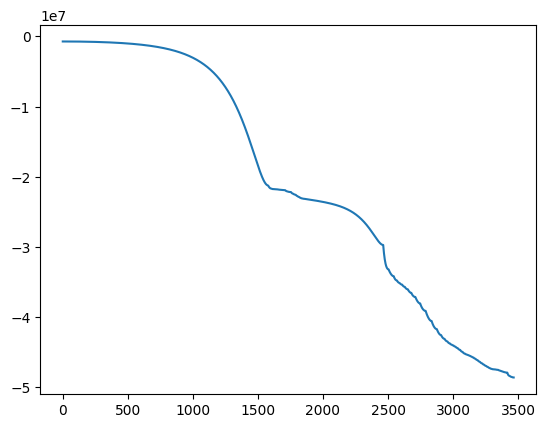

In [46]:
plt.plot(np.sum(np.sum(energies, axis = 1), axis = 1))

In [112]:
sim = Simulation(box,20000,2e-6)

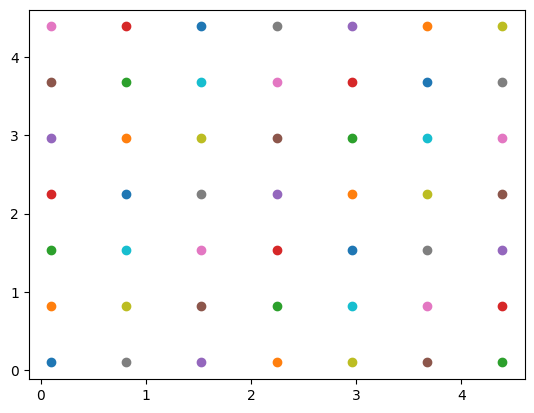

In [113]:
for i in range(sim.box.n_particles):
    plt.scatter(sim.box.particles_pos[i,0],sim.box.particles_pos[i,1])

In [114]:
sim.run()

C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_11908\4227146746.py:157: RuntimeWarning: divide by zero encountered in divide
  self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-self.c_6/(self.distance_abs**6)), 0)
C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_11908\4227146746.py:157: RuntimeWarning: invalid value encountered in subtract
  self.potEnergy_mat = np.where(self.distance_abs != 0, (self.c_12/(self.distance_abs**12)-self.c_6/(self.distance_abs**6)), 0)
C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_11908\4227146746.py:154: RuntimeWarning: divide by zero encountered in divide
  self.force_mat = np.where(distance_abs_newaxis != 0, (12*self.c_12/distance_abs_newaxis**14-6*self.c_6/distance_abs_newaxis**8)*self.distance_ghost, 0)
C:\Users\Peter Pain\AppData\Local\Temp\ipykernel_11908\4227146746.py:154: RuntimeWarning: invalid value encountered in subtract
  self.force_mat = np.where(distance_abs_newaxis != 0, (12*self.c_12/distance_ab

In [115]:
sim.pot_energy.shape

(49, 49, 20001)

In [116]:
anal = Analysis(sim)

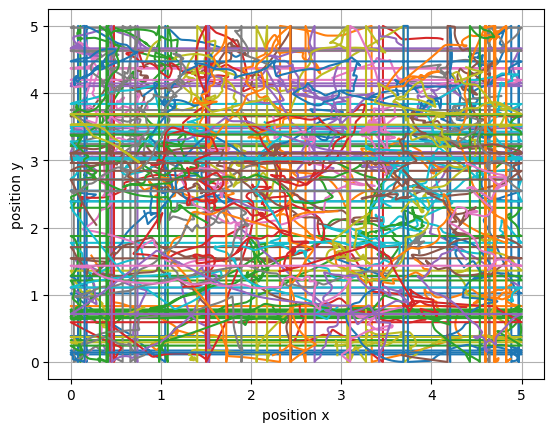

In [117]:
anal.show_traj()

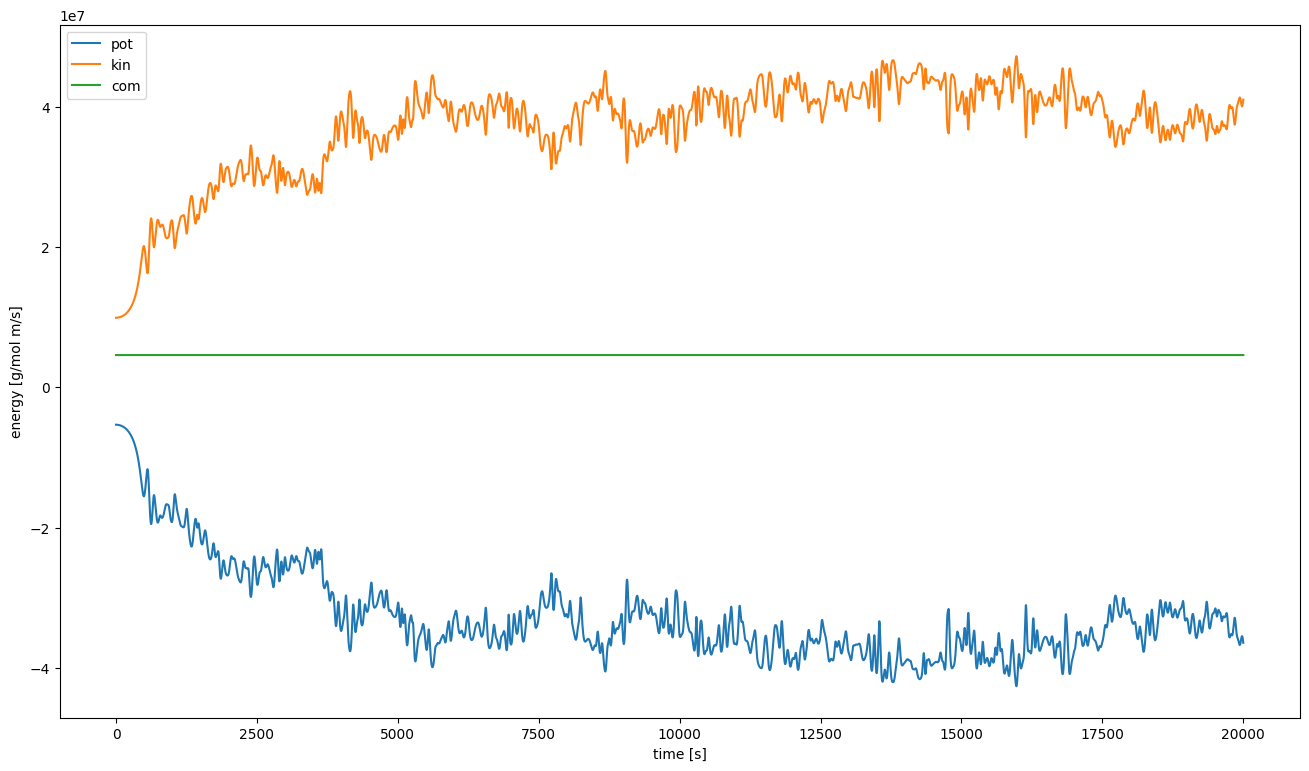

In [118]:
anal.plot_energies()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
for i in range(anal.sim.box.n_particles):
    ax.plot(np.sum(anal.sim.pot_energy,axis=0)[i])

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
for i in range(anal.sim.box.n_particles):
    ax.plot(anal.sim.kin_energy[i])

In [ ]:
plt.scatter(box.particles_pos[:,0],box.particles_pos[:,1])
for i in range(box.n_particles):
    plt.arrow(box.particles_pos[i+1,0],box.particles_pos[i,1],forces_summed[i,0]/2e6,forces_summed[i,1]/2e6)
    #plt.arrow(box.particles_pos[i,0],box.particles_pos[i,1],box.particles_vel[i,0]/150,box.particles_vel[i,1]/150)
box.move(dt = 2e-3)
box.wrap_around()
plt.scatter(box.particles_pos[:,0],box.particles_pos[:,1])
'''for i in range(box.n_particles):
    plt.arrow(box.particles_pos[i,0],box.particles_pos[i,1],forces_summed[i,0]/2e6,forces_summed[i,1]/2e6)'''